In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


import warnings
warnings.filterwarnings("ignore")
import sys
sys.path.append(r'D:\Hacks\re_new')

In [2]:
from src.utils import load_config, load_data, comp_score
from src.utils import cat_cols
from src.engine import get_model

config = load_config()
random_seed = config['RAND']

In [3]:
train_data, test_data = load_data()
train_data.shape, test_data.shape

((909604, 16), (303202, 15))

In [4]:
train_data.columns, test_data.columns

(Index(['timestamp', 'active_power_calculated_by_converter', 'active_power_raw',
        'ambient_temperature', 'generator_speed', 'generator_winding_temp_max',
        'grid_power10min_average', 'nc1_inside_temp', 'nacelle_temp',
        'reactice_power_calculated_by_converter', 'reactive_power',
        'wind_direction_raw', 'wind_speed_raw', 'wind_speed_turbulence',
        'turbine_id', 'Target'],
       dtype='object'),
 Index(['timestamp', 'active_power_calculated_by_converter', 'active_power_raw',
        'ambient_temperature', 'generator_speed', 'generator_winding_temp_max',
        'grid_power10min_average', 'nc1_inside_temp', 'nacelle_temp',
        'reactice_power_calculated_by_converter', 'reactive_power',
        'wind_direction_raw', 'wind_speed_raw', 'wind_speed_turbulence',
        'turbine_id'],
       dtype='object'))

In [5]:
model = get_model()
model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('targetencoder',
                                                  TargetEncoder(),
                                                  ['turbine_id'])])),
                ('xgbregressor',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=N...
                              gamma=None, gpu_id=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=None,
                              max_leaves=None, min_child_weight=None,
                              missing=nan, monotone_constraints=None,
                              n_estimators=2000, n_jobs=-1,
                              num_parallel_tree=None, predictor=None,
                              random_state=4567, reg_alpha=None,
                              reg_lambda=None, ...))])

In [6]:
from sklearn.model_selection import cross_val_score, KFold, train_test_split

X_train, X_val, y_train, y_val = train_test_split(train_data.drop(['timestamp', 'Target'], axis=1), train_data['Target'], test_size=0.2, random_state=random_seed)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((727683, 14), (181921, 14), (727683,), (181921,))

In [7]:
%%time
model.fit(X_train, y_train)
comp_score(model.predict(X_val), y_val)

[17:34:28] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


CPU times: total: 37.3 s
Wall time: 24.8 s


0.016062391647424703

<AxesSubplot:>

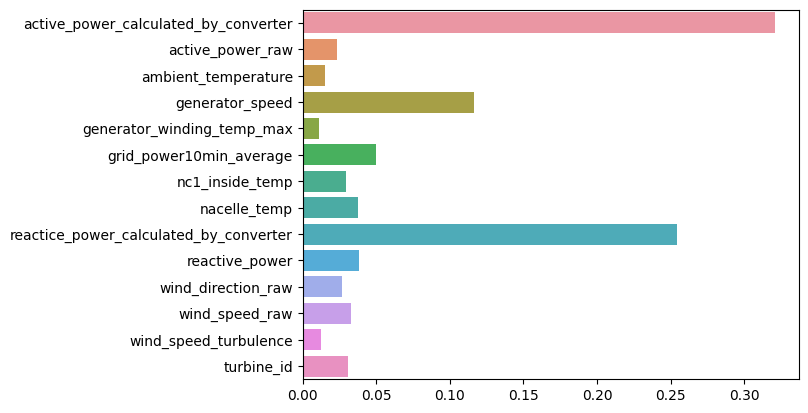

In [8]:
ft_imp = model[1].feature_importances_
fts = model.feature_names_in_

sns.barplot(x=ft_imp, y=fts)

In [9]:
X_val.columns == X_train.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

In [11]:
# recursive feature selection
fts = test_data.drop('timestamp', axis=1).columns
scores = []
for f in fts:
    print(f'Dropping {f} :')
    X_train_ = X_train.drop(f, axis=1)
    X_val_ = X_val.drop(f, axis=1)
    model.fit(X_train_, y_train)
    score = comp_score(model.predict(X_val_), y_val)
    scores.append(score)
    print(score)

Dropping active_power_calculated_by_converter :
[17:36:02] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


0.01605050076617172
Dropping active_power_raw :
[17:36:27] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


0.01605088845152611
Dropping ambient_temperature :
[17:36:51] WARNING: C

ValueError: A given column is not a column of the dataframe

In [14]:
np.argmin(scores)

8

In [15]:
min(scores)

0.016005028963767313

In [36]:
from sklearn.preprocessing import PolynomialFeatures
pf = PolynomialFeatures(degree=2, interaction_only=True)
pf3 = PolynomialFeatures(degree=3, interaction_only=False)

In [30]:
%%time
X_pf = pf.fit_transform(X_train.drop('turbine_id', axis=1))
X_pf.shape

CPU times: total: 891 ms
Wall time: 923 ms


(727683, 92)

In [37]:
X_pf3 = pf3.fit_transform(X_train.drop('turbine_id', axis=1))
X_pf3.shape

(727683, 560)

In [ ]:
xval_pf3 = pf3.transform(X_val.drop('turbine_id', axis=1))
xval_pf3.shape

In [39]:
pf3.n_output_features_

560

In [40]:
X_pf3

array([[1.00000000e+00, 8.87562622e+02, 9.13211283e+02, ...,
        2.60747408e+01, 1.21846515e+00, 5.69385268e-02],
       [1.00000000e+00, 3.61300337e+01, 2.30373845e+01, ...,
        7.64179795e+00, 1.10829165e+00, 1.60735785e-01],
       [1.00000000e+00, 4.02561907e+02, 4.05538919e+02, ...,
        1.29849541e+01, 1.17151635e+00, 1.05695450e-01],
       ...,
       [1.00000000e+00, 2.60280579e+02, 2.51484784e+02, ...,
        2.69368906e+01, 6.56138981e+00, 1.59824817e+00],
       [1.00000000e+00, 2.41653933e+02, 2.35842758e+02, ...,
        9.17170677e+00, 5.14018995e-01, 2.88076728e-02],
       [1.00000000e+00, 3.36857569e+02, 3.34137156e+02, ...,
        3.87968698e+01, 7.55033269e+00, 1.46938462e+00]])

In [33]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
Xspf3 = scaler.fit_transform(X_pf3)
Xspf3.shape

(727683, 378)

In [35]:
Xspf3[0]

array([ 0.00000000e+00,  7.62285280e-01,  7.78770069e-01, -8.09713824e-03,
        1.36264755e+00, -5.19164765e-01,  9.91797693e-01, -1.55809929e+00,
       -2.43587376e+00,  4.74259024e-01,  5.05374666e-01, -1.50748178e+00,
        1.18221328e+00, -8.41117175e-01,  3.75824207e-01,  7.10073521e-01,
        8.37370667e-01,  3.86171140e-01,  5.21012342e-01,  4.04230542e-01,
        2.63749772e-01,  2.75037640e-01,  2.89873523e-01, -5.78224090e-01,
        7.07575888e-01, -1.42446821e-01,  7.24996131e-01,  8.54586392e-01,
        3.98425954e-01,  5.33727701e-01,  4.16255556e-01,  2.73914808e-01,
        2.88611945e-01,  3.03054487e-01, -5.78938960e-01,  7.24353122e-01,
       -1.40302667e-01,  7.60925635e-01, -2.42986252e-01,  9.25252437e-01,
       -5.63661741e-01, -7.80410836e-01,  4.34612685e-01,  4.63680705e-01,
       -1.24724349e+00,  8.88510846e-01, -6.67749559e-01,  4.65020620e-01,
        1.07465752e+00,  1.59239277e-01, -2.82958160e-01,  6.31363783e-01,
        6.60344096e-01, -

(909604, 16)

In [45]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(Xspf3[:10_000], y_train[:10_000])
comp_score(lr.predict(Xspf3[10_000:]), y_train[10_000:])

0.03351219851650547

In [58]:
from sklearn.ensemble import HistGradientBoostingRegressor
spt = 20_000
hgb = HistGradientBoostingRegressor(random_state=random_seed, max_iter=1000, scoring='neg_mean_absolute_percentage_error', verbose=False, warm_start=True, validation_fraction=0.2)
hgb.fit(Xspf3[:spt], y_train[:spt])
comp_score(hgb.predict(Xspf3[spt:spt+20_000]), y_train[spt:spt+20_000])

0.02429504150158215